In [330]:
import cvxpy as cp
import numpy as np
np.set_printoptions(precision=3)

A12 = np.array([[1,3],[0,2]])
A21 = np.array([[1,0],[3,2]]).T
A13 = np.array([[1,0],[0,1]])
A23 = np.array([[1,0],[0,1]])
A31 = np.array([[-1,-1],[-1,-3]])
A32 = np.array([[-3,-3],[-1,-3]])

n_players = 3
n_actions = 2

w = cp.Variable(n_players)
x = cp.Variable((n_players, n_actions))
S = np.eye(n_actions)

obj = cp.Minimize(cp.sum(w))
constraints = []
constraints += [w[0] >= S[0]@(A12@x[1] + A13@x[2])]
constraints += [w[0] >= S[1]@(A12@x[1] + A13@x[2])]
constraints += [w[1] >= S[0]@(A21@x[0] + A23@x[2])]
constraints += [w[1] >= S[1]@(A21@x[0] + A23@x[2])]
constraints += [w[2] >= S[0]@(A31@x[0] + A32@x[1])]
constraints += [w[2] >= S[1]@(A31@x[0] + A32@x[1])]
constraints += [x >= 0, x@np.array([1, 1]) == 1]

prob = cp.Problem(obj, constraints)
val = prob.solve()
x_actual = x.value
print("Player 1:", x_actual[0])
print("Player 2:", x_actual[1])
print("Player 3:", x_actual[2])
print("zero:", val)


Player 1: [0.762 0.238]
Player 2: [0.802 0.198]
Player 3: [2.976e-08 1.000e+00]
zero: 7.2508696957885176e-06


In [432]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt

from jax import grad, jacobian, random, lax, vmap
key = random.PRNGKey(0)

from functools import partial
from collections import namedtuple

def softmax_2actions(a=[2.5,-2.5], b=[0, 1]):
    """ 2 action softmax """
    a = np.array(a)
    da = np.array([1, -1])*(a[0]-a[1])
    b = np.array(b)
    def pi(x):
        x = a*x + b    # affine shift 
        x -= np.max(x) # numerical stability, since pi(x) = pi(x+c)
        X = np.sum(np.exp(x))
        return np.exp(x)/X

    def dpi(x):
        p = pi(x)
        return (1 - p)*p*da
      
    def ddpi(x):
        return (1 - 2*pi(x))*dpi(x)*da
    
    return pi, dpi, ddpi

def polymatrix_3p_2a(A12,A21,A13,A31,A23,A32, 
                     softmax_temperature=2.5,
                     softmax_shift=0.5):
    
    pi, dpi, ddpi = \
    softmax_2actions([softmax_temperature, -softmax_temperature], softmax_shift)
    
    def f1(x1, x2, x3): return pi(x1)@A12@pi(x2) + pi(x1)@A13@pi(x3)
    def f2(x1, x2, x3): return pi(x2)@A21@pi(x1) + pi(x2)@A23@pi(x3)
    def f3(x1, x2, x3): return pi(x3)@A31@pi(x1) + pi(x3)@A32@pi(x2)
    
    def D1f1(x1, x2, x3): return dpi(x1)@A12@pi(x2) + dpi(x1)@A13@pi(x3)
    def D2f2(x1, x2, x3): return dpi(x2)@A21@pi(x1) + dpi(x2)@A23@pi(x3)
    def D3f3(x1, x2, x3): return dpi(x3)@A31@pi(x1) + dpi(x3)@A32@pi(x2)
    
    def D11f1(x1, x2, x3): return ddpi(x1)@A12@pi(x2) + ddpi(x1)@A13@pi(x3)
    def D12f1(x1, x2, x3): return dpi(x1)@A12@dpi(x2) 
    def D13f1(x1, x2, x3): return dpi(x1)@A13@dpi(x3) 
    def D21f2(x1, x2, x3): return dpi(x2)@A21@dpi(x1) 
    def D22f2(x1, x2, x3): return ddpi(x2)@A21@pi(x2) + ddpi(x2)@A23@pi(x3)
    def D23f2(x1, x2, x3): return dpi(x2)@A23@dpi(x3) 
    def D31f3(x1, x2, x3): return dpi(x3)@A31@dpi(x1) 
    def D32f3(x1, x2, x3): return dpi(x3)@A32@dpi(x2) 
    def D33f3(x1, x2, x3): return ddpi(x3)@A31@pi(x1)+ ddpi(x3)@A32@pi(x2) 
    
    def simgrad(*x): return np.hstack([D1f1(*x), D2f2(*x), D3f3(*x)])
    
    return (f1,f2,f3),(D1f1,D2f2,D3f3), \
           ((D11f1,D12f1,D13f1),(D21f2,D22f2,D23f2),(D31f3,D32f3,D33f3)),\
           simgrad 


""" Runs test on gradients """
softmax_temperature = 5.0
softmax_shift = 0.5
key = random.PRNGKey(0)
x = random.normal(key, (3,))
#x = np.array([0.1,-0.1,-0.2])
x = np.array([.115,.14,-1])
costs, gradients, jacobians, simgrad = \
    polymatrix_3p_2a(A12,A21,A13,A31,A23,A32,
                     softmax_temperature=softmax_temperature,
                     softmax_shift=softmax_shift)
pi, dpi, ddpi = \
    softmax_2actions([softmax_temperature, -softmax_temperature], softmax_shift)
f1, f2, f3 = costs
D1f1, D2f2, D3f3 = gradients
assert np.allclose(grad(f1, (0,))(*x)[0], D1f1(*x), atol=1e-5)
assert np.allclose(grad(f2, (1,))(*x)[0], D2f2(*x), atol=1e-5)
assert np.allclose(grad(f3, (2,))(*x)[0], D3f3(*x), atol=1e-5)

J = jacobian(simgrad, (0,1,2))(*x)
np.linalg.eigvals(J),J

(DeviceArray([-0.003+0.001j, -0.003-0.001j, -0.001+0.j   ], dtype=complex64),
 (DeviceArray([-0.001,  0.   , -0.002], dtype=float32),
  DeviceArray([-2.086e-06, -8.717e-04, -1.441e-03], dtype=float32),
  DeviceArray([ 0.002,  0.001, -0.005], dtype=float32)))

In [438]:
simgrad_ =  lambda *x: np.hstack([grad(f1, (0,))(*x)[0],\
                               grad(f1, (1,))(*x)[0], \
                               grad(f2, (2,))(*x)[0]])
J = jacobian(simgrad_, (0,1,2))(*x)
np.linalg.eigvals(J), J

(DeviceArray([ 1.918e+01+0.j,  2.743e-03+0.j, -8.612e-04+0.j], dtype=complex64),
 (DeviceArray([-0.001,  0.   ,  0.   ], dtype=float32),
  DeviceArray([2.980e-07, 1.918e+01, 1.441e-03], dtype=float32),
  DeviceArray([0.002, 0.   , 0.003], dtype=float32)))

In [440]:
import numpy as onp
J = onp.block([[j(*x) for j in jac]for jac in jacobians])
np.linalg.eigvals(J),J

(DeviceArray([-0.003+0.001j, -0.003-0.001j, -0.001+0.j   ], dtype=complex64),
 array([[-8.631e-04, -1.810e-06,  1.659e-03],
        [ 8.383e-07, -8.717e-04,  1.441e-03],
        [-1.659e-03, -1.441e-03, -5.093e-03]], dtype=float32))

In [450]:
from jax.lax import scan
num_iter = 100000
x0_1 = np.array([.115,.14,-1])
lr = 1e-2
lr = np.array([lr,lr,lr])
def update(x, t):
    x1,x2,x3 = x
    g = simgrad(*x)
    return np.hstack([x1 - lr[0]*g[0], x2 - lr[1]*g[1], x3 - lr[2]*g[2]]), x
xf, x_close = scan(update, x0_1, np.arange(num_iter))

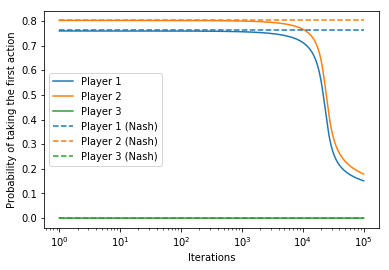

In [451]:
def plot_pi(x_):
    plt.plot(np.arange(num_iter)+1, vmap(pi)(x_[:,0])[:,0])
    plt.plot(np.arange(num_iter)+1, vmap(pi)(x_[:,1])[:,0])
    plt.plot(np.arange(num_iter)+1, vmap(pi)(x_[:,2])[:,0])
    plt.gca().set_prop_cycle(None)
    plt.plot([1,num_iter+1], [x_actual[0][0]]*2, '--')
    plt.plot([1,num_iter+1], [x_actual[1][0]]*2, '--')
    plt.plot([1,num_iter+1], [x_actual[2][0]]*2, '--')
    plt.xscale('log')
    plt.legend(['Player 1','Player 2','Player 3', \
                'Player 1 (Nash)', 'Player 2 (Nash)', 'Player 3 (Nash)'])
    plt.ylabel('Probability of taking the first action')
    plt.xlabel('Iterations')
plot_pi(x_close)
plt.savefig('figs/polymatrix-fail1.png')

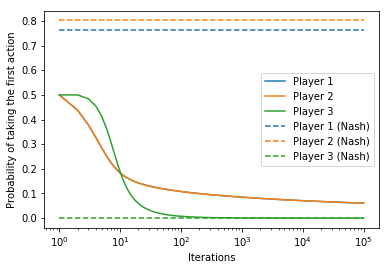

In [447]:
x0_2 = np.array([0.,0.,0.])
xf, x_zero = scan(update, x0_2, np.arange(num_iter))
plot_pi(x_zero)
plt.savefig('figs/polymatrix-fail2.png')

In [389]:
x_actual

array([[7.625e-01, 2.375e-01],
       [8.022e-01, 1.978e-01],
       [2.976e-08, 1.000e+00]])